In [636]:
import sys
from collections import defaultdict
import math
import re

import random
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import KMeans

In [3]:
def error(msg):
    print("*** ERROR ***\n", msg, "\n\n"); 
    input("Press Enter to continue...")
    sys.exit(0)

In [5]:
def invertEdge(E):
    """
    Invert the direction of an edge (V,W) -> (W,V)
    """
    return (E[1], E[0])

def edgeAfter(T , E):    
    """
    Return the next edge after E in T = (V1,V2,V3) with cyclic order
    """
    E1 = (T[0], T[1])
    E2 = (T[1], T[2])
    E3 = (T[2], T[0])
    if E == E1:
        return E2
    if E == E2:
        return E3
    if E == E3:
        return E1
    error(f"error in edgeAfter({T} , {E}), edge not found")

def edge(T, i):
    """
    Return edge number i in the triangle T = (V1, V2, V3)
    """
    return (T[0], T[1]) if i == 0 else ((T[1], T[2]) if i == 1 else ((T[2], T[0]) if i == 2 else error(f"error in edge({T} , {i}), incorrect i value")))

def rotateTriangleStartEdge(T,E):
    """
    Rotate a triangle T=(V1, V2, V3) so that it starts with a given edge E. 
    """
    if (T[0],T[1]) == E:
        return T
    if (T[1],T[2]) == E:
        return (T[1], T[2], T[0])
    if (T[2],T[0]) == E:
        return (T[2], T[0], T[1])
    error(f"error in rotateTriangleStartEdge({T} , {E}), edge not found")   



In [7]:
def splitFace(face):
    if (len(face) == 3):        
        return [tuple(face)]
    return [tuple(face[:3])] + splitFace([face[0]] + face[2:])

def getint(str, linenb):
    try:
        v = int(str)
        return v
    except:
        error(f"cannot convert [{str}] to int at line {linenb + 1}")

def getfloat(str, linenb):
    try:
        v = float(str)
        return v
    except:
        error(f"cannot convert [{str}] to int at line {linenb + 1}")

def parseFaceTag(f, lena, linenb):
    x = f.split("/")
    if len(x) == 0 or len(x) > 3:
        error(f"wrong face index: {f} at line {linenb+1}")
    if len(x) == 1:
        x += ['', '']
    if len(x) == 2:
        x += ['']            
    for i in range(3): 
        if x[i] == '':
            x[i] = -1
        else:
            v = getint(x[i], linenb)        
            if (v == 0):
                error(f"wrong face index: {f} at line {linenb+1} (index 0)")
            x[i] = (v - 1) if v > 0 else lena[i] + v                       
    return tuple(x)

In [9]:
def loadObjFile(filename):    
    """
    Load an .obj file. Return (vertice, texture, normal, obj, tag)
    
    where
    - vertice : list of verticles (as 3D numpy vectors)
    - texture : list of texture coords (as 3D numpy vectors) may be empty
    - normal  : list of normals (as 3D numpy vectors) may be empty    
    - obj: list of object. Each one being a list of triangles indices
    - tag: list of names of each object
    """

    vertice = []
    texture = []
    normal = []
    obj = []
    tag = []
    
    currentobj = []
    currentname = ""
    currenttagline = 0
    currentnb = 0
    
    print(f"Reading file {filename}.\n")
    try:
        with open(filename, "r") as f:
            lines = list(f)
    except:
        error(f"Cannot open file [{filename}]")
        
    for linenb , line in enumerate(lines): 
        l = line.split()
        if len(l) == 0:
            l = [""] # dummy value
        if l[0] == 'v':
            v = tuple(float(v) for v in l[1:])[:3]
            if len(v) != 3:
                error(f"found wrong vertex [v] (not 3 components) at line {linenb+1}")
            vertice.append(np.array(v, dtype=float))
            
        if l[0] == "vt":
            vt = tuple(float(t) for t in l[1:])[:2]
            if len(vt) != 2:
                error(f"found wrong texture coord [vt] (not 2 components) at line {linenb+1}")
            texture.append(np.array(vt, dtype=float))
           
        if l[0] == "vn":
            vn = tuple(float(n) for n in l[1:])[:3]
            if len(vn) != 3:
                error(f"found wrong normal [vn] (not 3 components) at line {linenb+1}")
            normal.append(np.array(vn, dtype=float))
            
        if l[0] == "o" or l[0] == "g" or l[0] == "usemtl":
            if len(currentobj) > 0:                
                print(f"--- found object {len(obj)+1} starting from tag [{currentname}] at line {currenttagline+1} with {len(currentobj)} triangles.")
                obj.append(currentobj)
                tag.append(currentname)
                currentobj = [] 
                currentname = "" if len(l) == 1 else " ".join(l)
                currenttagline = linenb
            else:
                currenttagline = linenb
                if len(l) >1:
                    currentname += " | " + " ".join(l)
                              
        if l[0] == 'f':
            face = [parseFaceTag(x , [len(vertice), len(texture), len(normal)], linenb) for x in l[1:]]
            currentobj += splitFace(face)
            
    if len(currentobj) > 0:                
                print(f"--- found object {len(obj)+1} starting from tag [{currentname}] at line {currenttagline+1} with {len(currentobj)} triangles.")
                obj.append(currentobj)
                tag.append(currentname)              
                
    if (len(obj) == 0):
        error("no faces found in the file !")

    setvi = set()
    setti = set()
    setni = set() 
    for o in obj:
        for T in o:
            for (v,t,n) in T:
                
                if v < 0:
                    error(f"negative vertex index {v} found in face {T}")
                if v >= len(vertice):
                    error(f"vertex index out of bound {v}/{len(vertice)} in face {T}")   
                setvi.add(v)
                
                if (t < -1) or (t >= len(texture)):
                    error(f"texture index out of bound {v}/{len(texture)} in face {T}")  
                setti.add(t)
                
                if (n < -1) or (n >= len(normal)):
                    error(f"normal index out of bound {v}/{len(normal)} in face {T}")  
                setni.add(n)       
           
    if len(setti) > 1 and -1 in setti:
        error(f"Missing texture indexes for some faces (but not all).")  

    if len(setni) > 1 and -1 in setni:
        error(f"Missing normal indexes for some faces (but not all).")  
            
    print(f"\nTOTAL :")
    print(f"- {len(vertice)} vertices [v]")        
    print(f"- {len(texture)} texture coords [vt]")
    print(f"- {len(normal)} normals [vn]\n")

    return vertice, texture, normal, obj, tag

In [11]:
def findBoundingBox(vertice):
    """
    Find the minimum bounding box of a list of vertices
    """
    xmin , ymin, zmin  = vertice[0]
    xmax , ymax, zmax  = vertice[0]
    for (x,y,z) in vertice:
        xmin = min(xmin,x)
        xmax = max(xmax,x)
        ymin = min(ymin,y)
        ymax = max(ymax,y)
        zmin = min(zmin,z)
        zmax = max(zmax,z)        
    return xmin,xmax,ymin,ymax,zmin,zmax


def recenterAndRescale(vertice, ask=True):
    """
    Recenter and rescale a list of vertice so that the bouding box fits in [-1,1]^3
    """
    pr = 2
    xmin,xmax,ymin,ymax,zmin,zmax = findBoundingBox(vertice)    
    print(f"\nBounding box of the model [{round(xmin,pr)},{round(xmax,pr)}]x[{round(ymin,pr)},{round(ymax,pr)}]x[{round(zmin,pr)},{round(zmax,pr)}]")
    ans = "y" if ask==False else input("Do you want to translate/resize the model to fit in [-1,1]^3 (y/N) ?")        
    if len(ans) > 0 and (ans.lower())[0] == "y":        
        cx = (xmin + xmax)/2
        cy = (ymin + ymax)/2
        cz = (zmin + zmax)/2
        mx = (xmax -xmin)/2
        my = (ymax -ymin)/2
        mz = (zmax -zmin)/2
        s = max(mx,my,mz)
        for i in range(len(vertice)):            
            x,y,z  = vertice[i]
            vertice[i] = ((x - cx)/s , (y-cy)/s, (z-cz)/s)                    
        xmin,xmax,ymin,ymax,zmin,zmax = findBoundingBox(vertice)        
    if len(ans) > 0 and (ans.lower())[0] == "y":        
        print(f"New bounding box [{round(xmin,pr)},{round(xmax,pr)}]x[{round(ymin,pr)},{round(ymax,pr)}]x[{round(zmin,pr)},{round(zmax,pr)}]\n")
    return vertice , (xmin,xmax,ymin,ymax,zmin,zmax)


def boundingBoxes(vertice, R):
    """
    Compute the bounding boxes for each object in R
    """
    res = []
    for O in R:
        #iterate over the objects
        vert = []
        for C in O:
            for _,T in C:
                for u, _, _ in T:
                    vert.append(vertice[u])  
        xmin,xmax,ymin,ymax,zmin,zmax = findBoundingBox(vert)
        res.append((xmin,xmax,ymin,ymax,zmin,zmax))
    return res

In [207]:
def dist(A, B):
    """ Compute the euclidian distance beetween 2 vectors """
    return np.linalg.norm(A-B)

def normVec(V):
    """ Return a normalized vector. Does nothing for 0 """
    norm = np.linalg.norm(V)
    return V if (norm == 0) else V/norm

def crossProduct(VA,VB):
    """ Compute the cross product between two vectors """
    return np.cross(VA,VB)

def Vec(VA, VB):
    """ Construct a vector from 2 vertices """
    return VB - VA

In [227]:
def fixNormals(vertice, normal, obj, ask = True, force_regeneration = False):
    """
    Compute the normals is not already present
    """
    if force_regeneration:        
        normal = []
    if len(normal) == 0:                
        print("No normal found. ", end="")
        ans = "y" if ask==False else input("Do you want to compute smooth normals (y/n) ?")       
        if len(ans) > 0 and ((ans.lower())[0] == "y" or (ans.lower())[0] == "o"):        
            # create the normals
            normal = [np.array([0.0, 0.0, 0.0], dtype=float)] * len(vertice)            
            for o in obj:
                for T0,T1,T2 in o:   
                    i0 = T0[0]
                    i1 = T1[0]
                    i2 = T2[0]
                    V0 = Vec(vertice[i1] , vertice[i0])
                    V1 = Vec(vertice[i2] , vertice[i1])
                    V2 = Vec(vertice[i0] , vertice[i2])
                    N0 = crossProduct(V2, V0)
                    N1 = crossProduct(V0, V1)
                    N2 = crossProduct(V1, V2)
                    N = N0 + N1 + N2                    
                    normal[i0] = normal[i0] + N
                    normal[i1] = normal[i1] + N
                    normal[i2] = normal[i2] + N                    
            # insert normal indexes in object
            for o in obj:
                for i in range(len(o)):                        
                    T1, T2, T3 = o[i]
                    o[i] = ((T1[0], T1[1], T1[0]),(T2[0], T2[1], T2[0]),(T3[0], T3[1], T3[0]))
        print(f"done.")

    # normalize the normals, even if we do not recompute them
    for i in range(len(normal)):
        normal[i] = normVec(normal[i])        
        n = np.linalg.norm(normal[i])
        if (n < 0.999) or (n > 1.001):
            print(f"error normal {normal[i]} (index {i}) with norm ={n}")
    print(f"number of normals: {len(normal)}")
    return normal  

In [520]:
def reorderObjectTriangles(obj, strategy = 0):
    """
    Take an object (ie list of triangles) and return a list of chains. 
    """
    availT = obj[:] # list of triangles. Set to none once used. 
    dicedge = defaultdict(lambda: []) # mapping from edge to triangles indexes
    firstTavail = 0 # first triangle available in availT
    nbTavail = len(obj) # number of triangle available in availT
    for i in range(len(obj)):                
        dicedge[edge(obj[i],0)].append(i)
        dicedge[edge(obj[i],1)].append(i)
        dicedge[edge(obj[i],2)].append(i)   
    
    # this method return a triangle index a given edge and mark it as used
    # or return none if no triangle available. 
    def findTriangleWithEdge(E):
        nonlocal availT
        nonlocal dicedge
        nonlocal firstTavail
        nonlocal nbTavail
        L = dicedge[E]
        while(len(L) > 0):
            i = L.pop()
            if availT[i] != None:
                TT = availT[i]
                availT[i] = None
                nbTavail -= 1
                return TT
        return None

    # return the next available triangle or none if all triangles have been used
    def getNextTriangle():
        nonlocal availT
        nonlocal firstTavail
        nonlocal nbTavail        
        if nbTavail == 0:
            return None
        nbTavail -= 1
        while(availT[firstTavail] == None):
            firstTavail += 1            
        T = availT[firstTavail]
        availT[firstTavail] = None              
        return T
        
    R = []    
    inv = 0
    
    while True:        
        # start a new chain 
        T = getNextTriangle()
        if (T == None):
            return R        
        C = [ (None, T) ]        
        E = edge(T, 2) 
        
        while True:
            MAXCHAINLEN = 65535
            if len(C) == MAXCHAINLEN:                
                break    

            nE0 = E
            nE1 = edgeAfter(T, nE0)
            nE2 = edgeAfter(T, nE1)

            # possibly swap nE1 and nE2 depending of strategy
            if (strategy == 1): # other direction
                nE1, nE2 = nE2, nE1                  
            elif (strategy == 2): # alternate direction
                if inv == 0:
                    nE1, nE2 = nE2, nE1 
                inv = 1 - inv
            elif (strategy == 3): #random
                if (np.random.rand() < 0.5):
                    nE1, nE2 = nE2, nE1 
            
            E = nE1
            T2 = findTriangleWithEdge(invertEdge(nE1))
            if T2 == None:
                E = nE2
                T2 = findTriangleWithEdge(invertEdge(nE2))
                if T2 == None:
                    if len(C) > 1:                        
                        break 
                    else:
                        E = nE0
                        T2 = findTriangleWithEdge(invertEdge(nE0))
                        if T2 == None:                            
                            break 
                  
            # got the next link in T2 with shared edge E
            pT = C[-1][1]
            n = None
            if (E == (pT[0], pT[1])):
                if len(C) > 1:
                    error("wrong next edge...")
                n = 2
            if (E == (pT[2], pT[0])):
                n = 0
            if (E == (pT[1], pT[2])):
                n = 1
            if n == None:
                    error("edge not found...")        
            E = invertEdge(E)            
            T = T2
            C.append((n, rotateTriangleStartEdge(T,E)))
            
        if len(C)>1:
            if C[1][0] == 2:
                C[0] = (None , ( C[0][1][1], C[0][1][2], C[0][1][0] )) 
                C[1] = (0, C[1][1])
        R.append(C)

In [1003]:
vertice, texture, normal, obj, tag = loadObjFile("spot.obj")

Reading file spot.obj.

--- found object 1 starting from tag [] at line 1 with 5856 triangles.

TOTAL :
- 2930 vertices [v]
- 3225 texture coords [vt]
- 0 normals [vn]



In [1005]:
def nbCompute(C):
    tot = 0
    for u in C: 
        tot = tot + (2 + len(u))
    return tot
    
def decoupe(ob, nbtry):
    totmin = 4*len(ob)
    for i in range(nbtry):    
        if i > 3:
            random.shuffle(ob)    
        C = reorderObjectTriangles(ob, (i%4))
        tot  = nbCompute(C)
        if tot < totmin:
            totmin = tot
            bestC = C
            print(f"{i} total number of triangle point to compute {tot}/{3*len(ob)} for {len(C)} chains\n")
    return bestC

In [1007]:
C = decoupe(obj[0], 50)

0 total number of triangle point to compute 6688/17568 for 416 chains



In [1009]:
nbCompute(C)

6688

In [1011]:
x = np.array([v[0] for v in vertice])
y = np.array([v[1] for v in vertice])
z = np.array([v[2] for v in vertice])

i = np.array([u[0][0] for u in obj[0]])
j = np.array([u[1][0] for u in obj[0]])
k = np.array([u[2][0] for u in obj[0]])

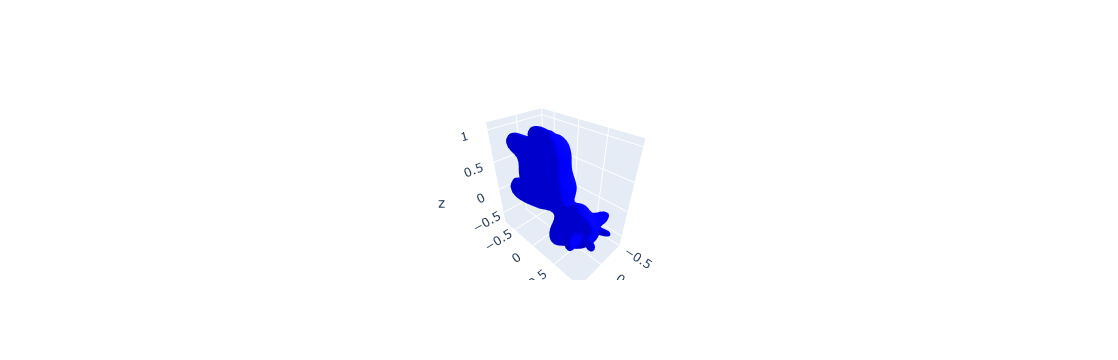

In [1013]:
fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=1, color="blue")])
fig.show()

In [1015]:
Nr = []
for n in range(len(i)):
    V1 = np.array([x[i[n]], y[i[n]], z[i[n]]])
    V2 = np.array([x[j[n]], y[j[n]], z[j[n]]])
    V3 = np.array([x[k[n]], y[k[n]], z[k[n]]])
    sU = Vec(V1, V2)
    sV = Vec(V1, V3)
    N = crossProduct(sU,sV)
    N = normVec(N)
    Nr += [N]

In [1017]:
alpha = 1.0
center = np.array([ [(x[i[n]] + x[j[n]] + x[k[n]])/3 , (y[i[n]] + y[j[n]] + y[k[n]])/3, (y[i[n]] + y[j[n]] + y[k[n]])/3, alpha*Nr[n][0], alpha*Nr[n][1], alpha*Nr[n][2] ]  for n in range(len(i))])

In [1023]:
nbclusters = int(np.sqrt(len(i))/2)
kmeans = KMeans(n_clusters=nbclusters, n_init=40)
kmeans.fit(center)

KMeans(n_clusters=38, n_init=40)

In [1025]:
palette = px.colors.qualitative.Dark24
colors = [palette[v % 24] for v in kmeans.labels_]

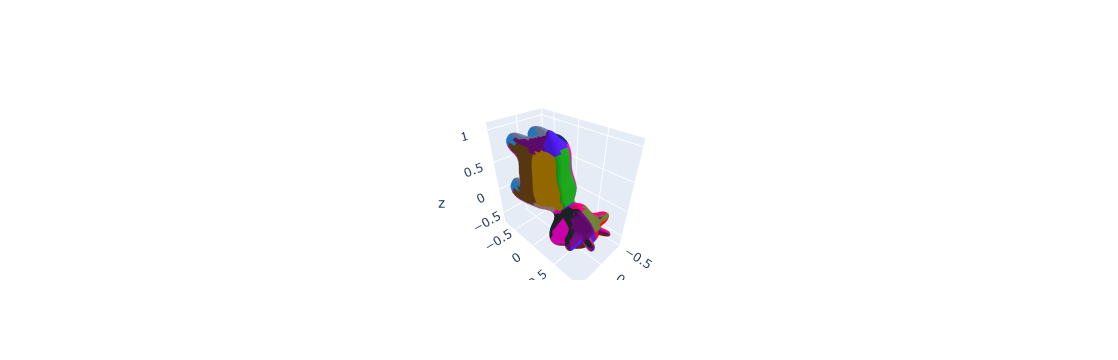

In [1027]:
fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k,
                   opacity=1,
                   facecolor=colors)])

fig.show()

In [1029]:
obj_meshlets = [ [] for _ in range(nbclusters) ]
for i in range(len(obj[0])):   
    obj_meshlets[kmeans.labels_[i]].append(obj[0][i])

In [1041]:
total = 0
for i in range(len(obj_meshlets)):
    print(f"- Optimizing meshlet {i}...")
    c = decoupe(obj_meshlets[i], 500)
    print(nbCompute(c))
    total = total + nbCompute(c)

print(f"total number of vertices to compute: {total}")

- Optimizing meshlet 0...
0 total number of triangle point to compute 316/738 for 35 chains

1 total number of triangle point to compute 308/738 for 31 chains

9 total number of triangle point to compute 298/738 for 26 chains

40 total number of triangle point to compute 292/738 for 23 chains

101 total number of triangle point to compute 290/738 for 22 chains

413 total number of triangle point to compute 288/738 for 21 chains

288
- Optimizing meshlet 1...
0 total number of triangle point to compute 204/444 for 28 chains

1 total number of triangle point to compute 196/444 for 24 chains

196
- Optimizing meshlet 2...
0 total number of triangle point to compute 344/804 for 38 chains

9 total number of triangle point to compute 340/804 for 36 chains

16 total number of triangle point to compute 334/804 for 33 chains

29 total number of triangle point to compute 312/804 for 22 chains

312
- Optimizing meshlet 3...
0 total number of triangle point to compute 142/306 for 20 chains

4 tota

In [1045]:
total - 6688

670

In [1033]:
1*1.1*0.7


0.77